<h1>Simple LSTM with Monthly Dataset</h1>

In [142]:
import os
import numpy as np 
import math
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# plt.style.use('fivethirtyeight')

In [143]:
def load_data(pathname):
    salmon_data = pd.read_csv(pathname)
    salmon_data.head()
    salmon_copy = salmon_data 
    salmon_copy.rename(columns = {"mo": "month", "da" : "day", "fc" : "king"}, inplace = True)
    salmon_copy['date']=pd.to_datetime(salmon_copy[['year','month','day']])
    king_data = salmon_copy.filter(["date","king"], axis=1)
    king_greater = king_data['date'].apply(pd.Timestamp) >= pd.Timestamp('01/01/1939')
    greater_than = king_data[king_greater]
    king_all = greater_than[greater_than['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2020')]
    king_all_copy = king_all
    king_all_copy = king_all_copy.reset_index()
    king_all_copy = king_all_copy.drop('index', axis=1)
    return king_all_copy, king_data

In [144]:
chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/passBonCS.csv'
ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/data.csv'
abdul_path = '/Users/abdul/Downloads/SalmonNet/passBonCS.csv'
king_all_copy, king_data= load_data(ismael_path)
print(king_all_copy)

            date  king
0     1939-01-01     0
1     1939-01-02     0
2     1939-01-03     0
3     1939-01-04     1
4     1939-01-05     0
...          ...   ...
24364 2020-12-25     0
24365 2020-12-26     0
24366 2020-12-27     0
24367 2020-12-28     0
24368 2020-12-29     0

[24369 rows x 2 columns]


In [145]:
data_copy = king_all_copy
data_copy['date']
data_copy.set_index('date', inplace=True)
data_copy.index = pd.to_datetime(data_copy.index)
data_copy = data_copy.resample('1M').sum()
data_copy

,king
date,
1939-01-31,6
1939-02-28,12
1939-03-31,121
1939-04-30,51410
1939-05-31,25159
...,...
2020-08-31,105269
2020-09-30,254930
2020-10-31,30917


In [146]:
print(data_copy)
data_copy.shape

              king
date              
1939-01-31       6
1939-02-28      12
1939-03-31     121
1939-04-30   51410
1939-05-31   25159
...            ...
2020-08-31  105269
2020-09-30  254930
2020-10-31   30917
2020-11-30     843
2020-12-31       9

[984 rows x 1 columns]


(984, 1)

In [147]:
data_copy.reset_index(inplace=True)
data_copy = data_copy.rename(columns = {'index':'date'})

In [148]:
print(data_copy)

          date    king
0   1939-01-31       6
1   1939-02-28      12
2   1939-03-31     121
3   1939-04-30   51410
4   1939-05-31   25159
..         ...     ...
979 2020-08-31  105269
980 2020-09-30  254930
981 2020-10-31   30917
982 2020-11-30     843
983 2020-12-31       9

[984 rows x 2 columns]


In [149]:
def create_train_test(king_all):
    king_training_parse = king_all['date'].apply(pd.Timestamp) <= pd.Timestamp('12/31/2015')
    king_training = king_all[king_training_parse]
    king_training = king_training.reset_index()
    king_training = king_training.drop('index', axis=1)
    
    king_test_parse = king_all['date'].apply(pd.Timestamp) > pd.Timestamp('12/31/2015')
    king_test = king_all[king_test_parse]
    king_test = king_test.reset_index()
    king_test = king_test.drop('index', axis=1)
    print(king_test.shape)
    
    # Normalizing Data
    king_training[king_training["king"] < 0] = 0 
    king_test[king_test["king"] < 0] = 0
    king_train_pre = king_training["king"].to_frame()
    king_test_pre = king_test["king"].to_frame()
    scaler = MinMaxScaler(feature_range=(0, 1))
    king_train_norm = scaler.fit_transform(king_train_pre)
    king_test_norm = scaler.fit_transform(king_test_pre)

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    y_test_not_norm = []
    y_train_not_norm = []
    
    for i in range(6,924): # 30
        x_train.append(king_train_norm[i-6:i])
        y_train.append(king_train_norm[i])
    for i in range(6, 60):
        x_test.append(king_test_norm[i-6:i])
        y_test.append(king_test_norm[i])
    
    # make y_test_not_norm
    for i in range(6, 60):
        y_test_not_norm.append(king_test['king'][i])
    for i in range(6,924): # 30
        y_train_not_norm.append(king_training['king'][i])
        
    return x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm

In [150]:
x_train, y_train, x_test, y_test, scaler, y_test_not_norm, y_train_not_norm = create_train_test(data_copy)
x_train = np.array(x_train)
x_test = np.array(x_test)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1)).astype(np.float32)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
y_train = np.array(y_train)
y_test = np.array(y_test)
y_test_not_norm = np.array(y_test_not_norm)
y_test_not_norm = y_test_not_norm.reshape((y_test_not_norm.shape[0], 1))
y_train_not_norm = np.array(y_train_not_norm)
y_train_not_norm = y_train_not_norm.reshape((y_train_not_norm.shape[0], 1))

(60, 2)


In [151]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Chinook Count')
    plt.plot(predicted, color='blue',label='Predicted Chinook Count')
    plt.title('Chinook Population Prediction')
    plt.xlabel('Time')
    plt.ylabel('Chinook Count')
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    
def month_to_year(month_preds):
    month_preds = month_preds[5:]
    print(len(month_preds))
    year_preds = []
    for i in range(12, len(month_preds), 12):   
        salmon_count = np.sum(month_preds[i - 12:i])
        year_preds.append(salmon_count)
    year_preds = pd.DataFrame(year_preds, columns = ["Count"])
    return year_preds

In [152]:
def create_LSTM_model(x_train, y_train, x_test, y_test): 
    '''
    Create LSTM model trained on X_train and Y_train
    and make predictions on the X_test data
    '''
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(5, return_sequences=True, input_shape=(x_train.shape[1],1)))
    LSTM_model.add(LSTM(5, return_sequences=True))
    LSTM_model.add(LSTM(5, return_sequences=True))
    LSTM_model.add(LSTM(1))
    #LSTM_model.add(Dense(1))
    LSTM_model.compile(loss='mean_squared_error', optimizer='adam')
    history_LSTM = LSTM_model.fit(x_train, y_train, epochs=400, batch_size=150, verbose=2)
    
    train_preds = LSTM_model.predict(x_train)
    test_preds = LSTM_model.predict(x_test)
    train_preds = scaler.inverse_transform(train_preds)
    test_preds = scaler.inverse_transform(test_preds)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)
    
    return LSTM_model, test_preds, train_preds, y_test, y_train, history_LSTM

In [153]:
# running LSTM
LSTM_model, test_preds_LSTM, train_preds_LSTM, y_test, y_train, history_LSTM = create_LSTM_model(x_train, y_train, x_test, y_test)

Epoch 1/400
7/7 - 5s - loss: 0.0108
Epoch 2/400
7/7 - 0s - loss: 0.0096
Epoch 3/400
7/7 - 0s - loss: 0.0092
Epoch 4/400
7/7 - 0s - loss: 0.0093
Epoch 5/400
7/7 - 0s - loss: 0.0093
Epoch 6/400
7/7 - 0s - loss: 0.0092
Epoch 7/400
7/7 - 0s - loss: 0.0092
Epoch 8/400
7/7 - 0s - loss: 0.0092
Epoch 9/400
7/7 - 0s - loss: 0.0092
Epoch 10/400
7/7 - 0s - loss: 0.0092
Epoch 11/400
7/7 - 0s - loss: 0.0092
Epoch 12/400
7/7 - 0s - loss: 0.0092
Epoch 13/400
7/7 - 0s - loss: 0.0092
Epoch 14/400
7/7 - 0s - loss: 0.0092
Epoch 15/400
7/7 - 0s - loss: 0.0092
Epoch 16/400
7/7 - 0s - loss: 0.0092
Epoch 17/400
7/7 - 0s - loss: 0.0092
Epoch 18/400
7/7 - 0s - loss: 0.0091
Epoch 19/400
7/7 - 0s - loss: 0.0091
Epoch 20/400
7/7 - 0s - loss: 0.0091
Epoch 21/400
7/7 - 0s - loss: 0.0091
Epoch 22/400
7/7 - 0s - loss: 0.0091
Epoch 23/400
7/7 - 0s - loss: 0.0091
Epoch 24/400
7/7 - 0s - loss: 0.0091
Epoch 25/400
7/7 - 0s - loss: 0.0091
Epoch 26/400
7/7 - 0s - loss: 0.0091
Epoch 27/400
7/7 - 0s - loss: 0.0091
Epoch 28/4

Epoch 220/400
7/7 - 0s - loss: 0.0079
Epoch 221/400
7/7 - 0s - loss: 0.0079
Epoch 222/400
7/7 - 0s - loss: 0.0078
Epoch 223/400
7/7 - 0s - loss: 0.0078
Epoch 224/400
7/7 - 0s - loss: 0.0078
Epoch 225/400
7/7 - 0s - loss: 0.0079
Epoch 226/400
7/7 - 0s - loss: 0.0078
Epoch 227/400
7/7 - 0s - loss: 0.0078
Epoch 228/400
7/7 - 0s - loss: 0.0077
Epoch 229/400
7/7 - 0s - loss: 0.0078
Epoch 230/400
7/7 - 0s - loss: 0.0078
Epoch 231/400
7/7 - 0s - loss: 0.0077
Epoch 232/400
7/7 - 0s - loss: 0.0079
Epoch 233/400
7/7 - 0s - loss: 0.0084
Epoch 234/400
7/7 - 0s - loss: 0.0082
Epoch 235/400
7/7 - 0s - loss: 0.0078
Epoch 236/400
7/7 - 0s - loss: 0.0077
Epoch 237/400
7/7 - 0s - loss: 0.0078
Epoch 238/400
7/7 - 0s - loss: 0.0077
Epoch 239/400
7/7 - 0s - loss: 0.0077
Epoch 240/400
7/7 - 0s - loss: 0.0076
Epoch 241/400
7/7 - 0s - loss: 0.0076
Epoch 242/400
7/7 - 0s - loss: 0.0076
Epoch 243/400
7/7 - 0s - loss: 0.0075
Epoch 244/400
7/7 - 0s - loss: 0.0076
Epoch 245/400
7/7 - 0s - loss: 0.0077
Epoch 246/40

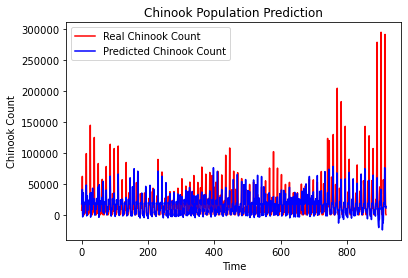

The root mean squared error is 23958.18224178563.


In [154]:
plot_predictions(y_train, train_preds_LSTM)
return_rmse(y_train, train_preds_LSTM)

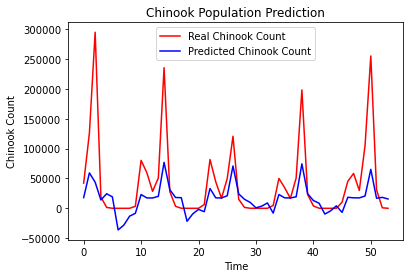

The root mean squared error is 56947.76536959329.


In [155]:
plot_predictions(y_test, test_preds_LSTM)
return_rmse(y_test, test_preds_LSTM)

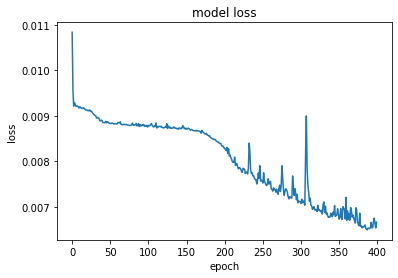

In [156]:
plot_loss(history_LSTM)

In [157]:
# global var for baseline
y_test_year = month_to_year(y_test)

49


In [158]:
y_test_year = month_to_year(y_test)
bs_chris_path = '/Users/chrisshell/Desktop/Stanford/SalmonData/Use Data/Forecast Data Update.csv'
bs_ismael_path = '/Users/ismaelcastro/Documents/Computer Science/CS Classes/CS230/project/forecast_data_17_20.csv'
bs_abdul_path = '/Users/abdul/Downloads/SalmonNet/Forecast Data Update.csv'
baseline_data = pd.read_csv(bs_ismael_path)
traditional = pd.DataFrame(baseline_data["Count"])
y_test_year = y_test_year.astype(np.int64)

49


In [159]:
# Comparing RMSE to curr Forecasting methods to LSTM
LSTM_test_year = month_to_year(test_preds_LSTM)
LSTM_test_year = LSTM_test_year.astype(np.int64)

49


In [160]:
LSTM_test_year

,Count
0,137251
1,178350
2,204074
3,166164


In [161]:
# test RMSE with baseline and LSTM
return_rmse(y_test_year, traditional)
return_rmse(y_test_year, LSTM_test_year)

The root mean squared error is 115854.5707848853.
The root mean squared error is 281408.2592577908.
